<img src="images/alice.jpg?raw=true"/>

As Alice's adventures in wonderland has taken a special place in our home, I found it a great fit to train a word2vec model, use bigrams and trigrams to include in the embeddings context around the words and to find out if similar words can be clustered to characters.

Several versions are available in the gutenberg.org project. For this notebook, I'll work with the [version](http://www.gutenberg.org/ebooks/28885) publicly available on the Gutenberg project since 2009.

The notebook is divided in the following steps:
* Import libraries
* Data load and pre-processing
* Text pre-processing
* Tokenization and lemmatization
* Create bigrams and trigrams
* Create and train a word2vec model
* Explore similarity of words resulting from the model
* Visualisation of similarity: are cluster of words related to characters from the book?


## Import libraries

In [63]:
import re
import spacy

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.summarization.textcleaner import get_sentences

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
print("Libraries imported")

Libraries imported


# Data load and pre-processing

In [64]:
# Load raw text
file = "text/alice.txt"
with open(file, encoding='latin-1') as f:
    book_raw_text = f.readlines()
    
# View the first 20 rows 
book_raw_text[:20]

["Project Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll\n",
 '\n',
 'This eBook is for the use of anyone anywhere at no cost and with\n',
 'almost no restrictions whatsoever.  You may copy it, give it away or\n',
 're-use it under the terms of the Project Gutenberg License included\n',
 'with this eBook or online at www.gutenberg.net\n',
 '\n',
 '\n',
 "Title: Alice's Adventures in Wonderland\n",
 '       Illustrated by Arthur Rackham. With a Proem by Austin Dobson\n',
 '\n',
 'Author: Lewis Carroll\n',
 '\n',
 'Illustrator: Arthur Rackham\n',
 '\n',
 'Release Date: May 19, 2009 [EBook #28885]\n',
 '\n',
 'Language: English\n',
 '\n',
 '\n']

The book is structured in:
* Preamble about the publication.
* A poem.
* Table of contents.
* List of plates.
* Twelve chapters with content.

We will focus on the content in the chapters and split the book in the corresponding twelve sections. 
<br>Each chapter starts with the word "CHAPTER", so we will take this as basis to make the split.

In [65]:
chapters = "".join(book_raw_text).split("CHAPTER")
len(chapters)

13

We remove the first entry on the list of chapters as it corresponds to the preamble, poem, table of contents and list of plates.

In [66]:
chapters.pop(0)

'Project Gutenberg\'s Alice\'s Adventures in Wonderland, by Lewis Carroll\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.net\n\n\nTitle: Alice\'s Adventures in Wonderland\n       Illustrated by Arthur Rackham. With a Proem by Austin Dobson\n\nAuthor: Lewis Carroll\n\nIllustrator: Arthur Rackham\n\nRelease Date: May 19, 2009 [EBook #28885]\n\nLanguage: English\n\n\n*** START OF THIS PROJECT GUTENBERG EBOOK ALICE\'S ADVENTURES IN WONDERLAND ***\n\n\n\n\nProduced by Jana Srna, Emmy and the Online Distributed\nProofreading Team at http://www.pgdp.net (This file was\nproduced from images generously made available by the\nUniversity of Florida Digital Collections.)\n\n\n\n\n\n\n\n\n\n\n\nALICE\'S ADVENTURES IN WONDERLAND\n\n[Illustration: "Alice"]\n\n[Illustration:\n\n          ALICE\'SÂ·ADV

In [67]:
num_chapters = len(chapters)
num_chapters

12

Tha last chapter contains additional license information after the end of the story which is marked with "THE END". As this additional information is not relevant to the story, we will split it to separate the story from the licensing info and subsequently we will replace the last chapter with the content that is relevant to the story.

In [68]:
chapters[num_chapters - 1]

' XII\n\n\n[Sidenote: _Alice\'s Evidence_]\n\n"HERE!" cried Alice, quite forgetting in the flurry of\nthe moment how large she had grown in the last few minutes, and she\njumped up in such a hurry that she tipped over the jury-box with the\nedge of her skirt, upsetting all the jurymen on to the heads of the\ncrowd below, and there they lay sprawling about, reminding her very much\nof a globe of gold-fish she had accidentally upset the week before.\n\n"Oh, I _beg_ your pardon!" she exclaimed in a tone of great dismay, and\nbegan picking them up again as quickly as she could, for the accident of\nthe gold-fish kept running in her head, and she had a vague sort of idea\nthat they must be collected at once and put back into the jury-box, or\nthey would die.\n\n"The trial cannot proceed," said the King in a very grave voice, "until\nall the jurymen are back in their proper places--_all_," he repeated\nwith great emphasis, looking hard at Alice as he said so.\n\nAlice looked at the jury-box,

In [69]:
end = chapters[num_chapters - 1].split("THE END")
chapters[len(chapters)-1] = end[0]

In [70]:
#chapters[num_chapters - 1]

In [71]:
# Display the first 30 characters of each chapter
for chapter in chapters:
    print(chapter[:30])

 I


[Sidenote: _Down the Rabb
 II


[Sidenote: _Pool of Tear
 III


[Sidenote: _A Caucus-ra
 IV


[Sidenote: _The Rabbit s
 V


[Sidenote: _Advice from a
 VI


[Sidenote: _Pig and Pepp
 VII


[Sidenote: _A Mad Tea-p
 VIII


[Sidenote: _The Queen'
 IX


[Sidenote: _The Mock Tur
 X


[Sidenote: _The Lobster Q
 XI


[Sidenote: _Who Stole th
 XII


[Sidenote: _Alice's Evi


## Text pre-processing
Steps:
1. Remove chapter titles, illustrations and sidenotes
2. Remove new line, * and _ characters

In [72]:
# Remove first line in each chapter (the chapter number)
chapters = [re.sub(r"^.*\n", "", sent) for sent in chapters]

# Remove chapters titles/illustraions/sidenotes - these are of the form "[text]"
chapters = [re.sub("[\[].*?[\]]", " ", sent) for sent in chapters]

# Remove one or more spaces and new lines
chapters = [re.sub("\s+", " ", sent) for sent in chapters]

# Remove the ***** text lines in the text
chapters = [re.sub("\*", " ", sent) for sent in chapters]

# Remove the _ characters in the text
chapters = [re.sub("_", " ", sent) for sent in chapters]

# Lets look at how the text now looks
for chapter in chapters:
    print("Chapter {}: {}".format(chapters.index(chapter)+1,chapter[:50]))

Chapter 1:  ALICE was beginning to get very tired of sitting 
Chapter 2:  "CURIOUSER and curiouser!" cried Alice (she was s
Chapter 3:  THEY were indeed a queer-looking party that assem
Chapter 4:  IT was the White Rabbit, trotting slowly back aga
Chapter 5:  THE Caterpillar and Alice looked at each other fo
Chapter 6:  FOR a minute or two she stood looking at the hous
Chapter 7:  THERE was a table set out under a tree in front o
Chapter 8:  A LARGE rose-tree stood near the entrance of the 
Chapter 9:  "YOU can't think how glad I am to see you again, 
Chapter 10:  THE Mock Turtle sighed deeply, and drew the back 
Chapter 11:  THE King and Queen of Hearts were seated on their
Chapter 12:  "HERE!" cried Alice, quite forgetting in the flur


In [73]:
chapter_sentences = [list(get_sentences(doc)) for doc in chapters]

In [74]:
len(chapter_sentences[:])

12

In [75]:
total = 0
for i in range(len(chapter_sentences)):
    print("Phrases in chapter {}: {}".format(i+1,len(list(chapter_sentences[i]))))
    total = total + len(list(chapter_sentences[i]))
print("Phrases in total: {}".format(total))

Phrases in chapter 1: 60
Phrases in chapter 2: 79
Phrases in chapter 3: 64
Phrases in chapter 4: 95
Phrases in chapter 5: 73
Phrases in chapter 6: 99
Phrases in chapter 7: 98
Phrases in chapter 8: 80
Phrases in chapter 9: 85
Phrases in chapter 10: 93
Phrases in chapter 11: 77
Phrases in chapter 12: 69
Phrases in total: 972


In [76]:
chapter_sentences[0][:5]

['ALICE was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, "and what is the use of a book," thought Alice, "without pictures or conversations?" So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid) whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.',
 'There was nothing so  very  remarkable in that; nor did Alice think it so  very  much out of the way to hear the Rabbit say to itself, "Oh dear!',
 'Oh dear!',
 'I shall be too late!" (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually  took a watch out of its waistcoat-pocket , 

We no longer want the sentences per chapter - word2vec just wants a list of sentences. So lets flatten the chapter list

In [77]:
sentences = [item for chapter in chapter_sentences for item in chapter]
len(sentences)

972

In [78]:
sentences[:5]

['ALICE was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, "and what is the use of a book," thought Alice, "without pictures or conversations?" So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid) whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.',
 'There was nothing so  very  remarkable in that; nor did Alice think it so  very  much out of the way to hear the Rabbit say to itself, "Oh dear!',
 'Oh dear!',
 'I shall be too late!" (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually  took a watch out of its waistcoat-pocket , 

## Tokenization and lemmatization
Tokenise all sentences removing punctuation.

In [79]:
# dacc=False removes punctuation
tokenised_sentences = [simple_preprocess(str(sentence), deacc=False) for sentence in sentences]
print(len(tokenised_sentences))
# Lets view the words of the first sentence of the first chapter
print(tokenised_sentences[0])

972
['alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank', 'and', 'of', 'having', 'nothing', 'to', 'do', 'once', 'or', 'twice', 'she', 'had', 'peeped', 'into', 'the', 'book', 'her', 'sister', 'was', 'reading', 'but', 'it', 'had', 'no', 'pictures', 'or', 'conversations', 'in', 'it', 'and', 'what', 'is', 'the', 'use', 'of', 'book', 'thought', 'alice', 'without', 'pictures', 'or', 'conversations', 'so', 'she', 'was', 'considering', 'in', 'her', 'own', 'mind', 'as', 'well', 'as', 'she', 'could', 'for', 'the', 'hot', 'day', 'made', 'her', 'feel', 'very', 'sleepy', 'and', 'stupid', 'whether', 'the', 'pleasure', 'of', 'making', 'daisy', 'chain', 'would', 'be', 'worth', 'the', 'trouble', 'of', 'getting', 'up', 'and', 'picking', 'the', 'daisies', 'when', 'suddenly', 'white', 'rabbit', 'with', 'pink', 'eyes', 'ran', 'close', 'by', 'her']


### Create bigrams and trigrams 
Create bigram and trigrams from the tokenised and then lemmatized sentences using phraser objects.

In [98]:
bigram_phrases = Phrases(tokenised_sentences, min_count=2, threshold=1)
bigram = Phraser(bigram_phrases)

trigram_phrases = Phrases(bigram[tokenised_sentences], min_count=1, threshold=1, delimiter=b'_')
trigram = Phraser(trigram_phrases)

In [99]:
bigram

In [100]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

# Gensim simple processing pipeline - lowercase and tokensises 
def simple_preprocessing(texts):
    return [[word for word in simple_preprocess(str(doc))] for doc in texts]

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    use spaCy lemmatisation - allowing through Nouns, Adjectives, Verbs and adverbs only
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ != '-PRON-'])
    return texts_out

In [101]:
# Simple Genism processing 

tokens_preprocessed = simple_preprocessing(tokenised_sentences)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
tokens_lemmatized = lemmatization(tokens_preprocessed, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Form Bigrams
tokens_bigrams = make_bigrams(tokens_lemmatized)

# Form Trigrams
tokens_trigrams = make_trigrams(tokens_bigrams)

data_processed = tokens_trigrams

#  lets look at the first and fifth sentences
print(data_processed[0])
print(data_processed[4])

['begin', 'very_tired', 'sit', 'sister', 'bank', 'have', 'once', 'twice', 'peep', 'book', 'sister', 'read', 'picture', 'conversation', 'use', 'book', 'think', 'alice', 'picture', 'conversation', 'consider', 'own', 'mind', 'as_well', 'could', 'hot', 'day', 'make', 'feel_very', 'sleepy', 'stupid', 'pleasure', 'make', 'daisy', 'chain', 'would', 'worth', 'trouble', 'get', 'pick', 'daisy', 'when_suddenly', 'white_rabbit', 'pink', 'eye', 'run', 'close']
['moment', 'down', 'go', 'alice', 'never', 'once', 'consider', 'how', 'world', 'again']


## Create and train a word2vec model

In [102]:
# Initialise the model - CBOW or skipgram
w2v_model = Word2Vec(min_count=1,
                     window=5,
                     size=300,
                     sg=1) 

#  – CBOW (Continuous bag-of-words): The order of the context words does not influence prediction
#  – Skip-grams: nearby context words are weighted more heavily than distant ones.

In [103]:
# Build the vocab
w2v_model.build_vocab(data_processed, progress_per=10000)

In [104]:
# Train the model
w2v_model.train(data_processed, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(299195, 352770)

In [105]:
# Normalise the Word2vec vectors, needed for some similarity measures
w2v_model.init_sims(replace=True)

## Explore similarity of words resulting from the model

In [106]:
vocab = list(w2v_model.wv.vocab)
print ("Vocal length %d" % len(vocab))
print('Examples: %s' % vocab[:50])

Vocal length 2001
Examples: ['begin', 'very_tired', 'sit', 'sister', 'bank', 'have', 'once', 'twice', 'peep', 'book', 'read', 'picture', 'conversation', 'use', 'think', 'alice', 'consider', 'own', 'mind', 'as_well', 'could', 'hot', 'day', 'make', 'feel_very', 'sleepy', 'stupid', 'pleasure', 'daisy', 'chain', 'would', 'worth', 'trouble', 'get', 'pick', 'when_suddenly', 'white_rabbit', 'pink', 'eye', 'run', 'close', 'so_very', 'remarkable', 'much', 'way', 'hear', 'rabbit', 'say', 'dear', 'shall']


In [107]:
w2v_model.wv.similar_by_word("queen", topn=10)

[('shout', 0.9366840124130249),
 ('heart', 0.9234737753868103),
 ('voice', 0.9169950485229492),
 ('knave', 0.9089837670326233),
 ('off', 0.9083384275436401),
 ('king', 0.8953638672828674),
 ('player', 0.8934125304222107),
 ('hear', 0.8871649503707886),
 ('turn', 0.8870571851730347),
 ('quarrel', 0.8788375854492188)]

In [108]:
w2v_model.wv.most_similar(negative=["queen"], topn=5)

[('grow', -0.010288625955581665),
 ('able', -0.014845384284853935),
 ('ootiful', -0.04174365475773811),
 ('eat', -0.12900513410568237),
 ('large', -0.18090635538101196)]

In [109]:
w2v_model.wv.similarity('alice', 'venture')

0.9147519

In [110]:
w2v_model.wv.similarity('alice', 'hurry')

0.5489847

In [111]:
w2v_model.wv.doesnt_match("alice queen hatter caterpillar rat".split())

/git/github.com/kwulffert/covid-19-analysis/.venv-af/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'queen'

In [118]:
def get_word_table(table, key):
    return pd.DataFrame(table, columns=[key, 'similarity'])

keys = [ 'alice', 'cheshire_cat', 'turtle', 'queen', 'caterpillar', 'hatter', 'gryphon','duchess']
tables = []
for key in keys:
    #tables.append(get_word_table(w2v_model.wv.similar_by_word(key), key))
    tables.append(get_word_table(w2v_model.wv.similar_by_word(key, topn=30), key))
    w2v_model.wv.most_similar(word, topn=30)
pd.concat(tables, axis=1)

,alice,similarity,cheshire_cat,similarity,turtle,similarity,queen,similarity,caterpillar,similarity,hatter,similarity,gryphon,similarity,duchess,similarity
0,name,0.958373,lovely_garden,0.993608,stuff,0.993133,shout,0.936684,sobs,0.975401,well,0.963960,feeble,0.990275,dig,0.942050
1,better,0.957184,right_size,0.993509,fellow,0.992806,heart,0.923474,rub,0.973195,tea,0.947729,tis,0.989896,pig,0.940542
2,shall,0.956770,occur,0.992423,teach,0.991951,voice,0.916995,slowly,0.972156,bottom,0.947008,alone,0.989530,growl,0.932070
3,let,0.950646,very_uncomfortable,0.991509,should_like,0.991831,knave,0.908984,hookah,0.971484,butter,0.934454,sobs,0.988791,choose,0.931257
4,child,0.949097,shoulder,0.990069,hollow,0.991658,off,0.908338,while,0.971063,of_course,0.926154,meal,0.988369,of_course,0.930912
5,else,0.948170,tired,0.989736,line,0.991628,king,0.895364,unfold,0.970981,majesty,0.922408,beginning,0.988285,please,0.930101
6,trial,0.947610,hole,0.989719,hoarse,0.991537,player,0.893413,alone,0.970654,riddle,0.918882,thunder,0.988033,come_back,0.928283
7,little_timidly,0.946968,expect,0.989697,holiday,0.991405,hear,0.887165,spectacle,0.968984,sleep,0.917718,indignant,0.988021,sharp_little,0.927655
8,glad,0.946766,giddy,0.989417,likely,0.991300,turn,0.887057,silence,0.968926,bread,0.915512,lonely,0.988016,angry,0.927330
9,understand,0.945145,escape,0.989296,uglification,0.991289,quarrel,0.878838,yawn,0.968838,name,0.915442,great_hurry,0.987886,riddle,0.927272


## Embeddings Visualisation

We will visualise embeddings of the 30 words with highest similarity to a set of characters: Alice, the cheshire cat and the mock turtle.
<br> As the embeddings have 300 dimensions, we will use t-Distributed Stochastic Neighbor Embedding (t-SNE) to reduce the dimensions to 2 and plot the embeddings using matplotlib.

Alice    |  Cheshire cat  |    Mock turtle
:-------------------------:|:-------------------------:|:-------------------------:
<img src="images/alice.jpeg?raw=true"/>  | <img src="images/alice_cat.jpg?raw=true"/> |  <img src="images/turtle.jpg?raw=true"/>  

In [113]:
keys = ['alice', 'cheshire_cat', 'turtle']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [114]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=5, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

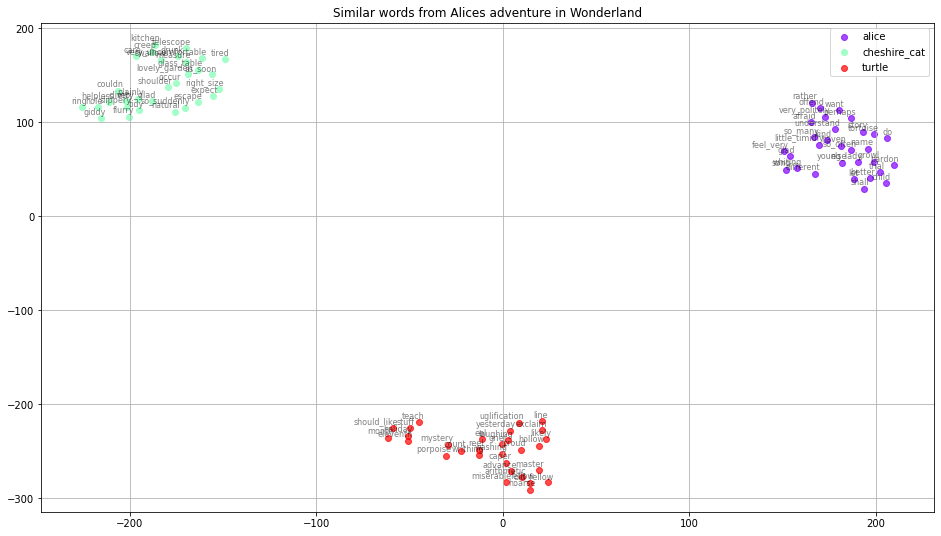

In [116]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
            
    plt.legend(loc=1)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Alice''s adventure in Wonderland', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')